# Sport Analysis


## 1. Import Libraries

In [ ]:
# !pip install mplsoccer
# !pip install pdpbox

In [2]:
import numpy as np
import pandas as pd
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mplsoccer.pitch import Pitch, add_image
from scipy.ndimage import gaussian_filter
import scikitplot as skplt 

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

import shap
from pdpbox import pdp, get_dataset, info_plots

# 2. Check data

In [3]:
shots_euro_champ = pd.read_csv('/coursedata/sport_data/shots_European_Championship.csv')
shots_euro_champ.head()

,period,time,x,y,freeKick,rightFoot,leftFoot,head,opportunity,goal
0,1,31,91,29,0,1,0,0,0,0
1,1,143,71,29,0,1,0,0,1,0
2,1,220,96,57,0,1,0,0,1,0
3,1,248,96,61,0,0,0,1,1,0
4,1,557,75,33,0,0,1,0,0,0


In [4]:
shots_world_cup = pd.read_csv('/coursedata/sport_data/shots_World_Cup.csv')
shots_world_cup.head()

,period,time,x,y,target,freeKick,rightFoot,leftFoot,head,opportunity,goal
0,1,327,87,27,1.0,0,1,0,0,0,0
1,1,407,90,69,0.0,0,1,0,0,0,0
2,1,526,86,30,0.0,0,0,1,0,0,0
3,1,693,93,60,0.0,0,0,0,1,1,1
4,1,1266,86,38,1.0,0,0,1,0,0,0


In [5]:
shots_france = pd.read_csv('/coursedata/sport_data/shots_France.csv')
shots_france.head()

,period,time,x,y,freeKick,rightFoot,leftFoot,head,opportunity,goal
0,1,606,94,57,0,1,0,0,1,1
1,1,859,83,42,0,0,0,1,0,0
2,1,1568,96,43,0,1,0,0,1,1
3,1,1801,84,21,0,1,0,0,0,0
4,1,2010,73,51,0,1,0,0,1,0


In [6]:
shots_germany = pd.read_csv('/coursedata/sport_data/shots_Germany.csv')
shots_germany.head()

,period,time,x,y,freeKick,rightFoot,leftFoot,head,opportunity,goal
0,1,248,83,66,0,1,0,0,1,0
1,1,529,95,59,0,0,0,1,1,1
2,1,668,91,66,0,1,0,0,1,0
3,1,673,88,49,0,1,0,0,1,0
4,1,949,74,42,0,1,0,0,0,0


In [7]:
shots_italy = pd.read_csv('/coursedata/sport_data/shots_Italy.csv')
shots_italy.head()

,period,time,x,y,freeKick,rightFoot,leftFoot,head,opportunity,goal
0,1,194,80,41,0,1,0,0,1,0
1,1,251,95,33,0,0,1,0,1,0
2,1,634,72,63,0,1,0,0,0,0
3,1,1359,91,62,0,1,0,0,1,0
4,1,1413,86,26,0,0,1,0,0,0


In [8]:
shots_spain = pd.read_csv('/coursedata/sport_data/shots_Spain.csv')
shots_spain.head()

,period,time,x,y,freeKick,rightFoot,leftFoot,head,opportunity,goal
0,1,58,93,34,0,0,1,0,1,0
1,1,61,80,59,0,1,0,0,0,0
2,1,447,88,57,0,1,0,0,1,0
3,1,489,87,66,0,1,0,0,1,0
4,1,949,75,40,0,1,0,0,0,0


In [9]:
shots_england = pd.read_csv('/coursedata/sport_data/shots_England.csv')
shots_england.head()

,period,time,x,y,freeKick,rightFoot,leftFoot,head,opportunity,goal
0,1,95,88,41,0,1,0,0,1,1
1,1,180,85,52,0,0,1,0,1,0
2,1,255,96,52,0,0,0,1,1,1
3,1,426,81,33,0,0,1,0,1,0
4,1,815,75,30,0,1,0,0,1,0


In [10]:
shots_world_cup.drop('target', axis=1, inplace=True)

In [11]:
# create indicator for the competition
shots_euro_champ['competition'] = 'european' 
shots_world_cup['competition'] = 'worldcup'
shots_france['competition'] = 'france' 
shots_germany['competition'] = 'germany'
shots_italy['competition'] = 'italy'
shots_spain['competition'] = 'spain'
shots_england['competition'] = 'england'

## Merge Dataset

In [12]:
# merge dataset
data = shots_euro_champ.append([shots_world_cup,shots_france,shots_germany,shots_italy,shots_spain,shots_england], ignore_index=True)
data.shape

(45287, 11)

In [13]:
# display data
data.tail(2)

,period,time,x,y,freeKick,rightFoot,leftFoot,head,opportunity,goal,competition
45285,2,2381,92,38,0,1,0,0,1,0,england
45286,2,2834,86,50,0,0,0,1,1,0,england


# 3. Exploratory Data Analysis

## Geometry 

Position of the shot

In [14]:
# x, y coordinates in meters
data['x'] = data['x'] * 125 / 100
data['y'] = data['y'] * 85 / 100
data.head(2)

,period,time,x,y,freeKick,rightFoot,leftFoot,head,opportunity,goal,competition
0,1,31,113.75,24.65,0,1,0,0,0,0,european
1,1,143,88.75,24.65,0,1,0,0,1,0,european


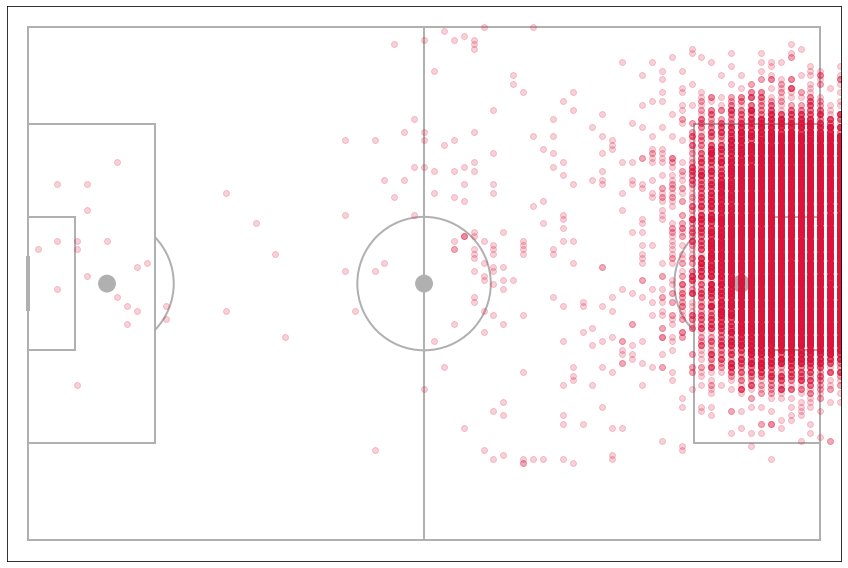

In [15]:
# visualize reference to https://mplsoccer.readthedocs.io/en/latest/gallery/pitch_setup/plot_pitches.html
pitch = Pitch(pitch_type='wyscout', figsize=(12,8), spot_scale=0.01, axis=True)
fig, ax = pitch.draw()
pitch.scatter(data.x, data.y, ax=ax, color='crimson', alpha=0.2);

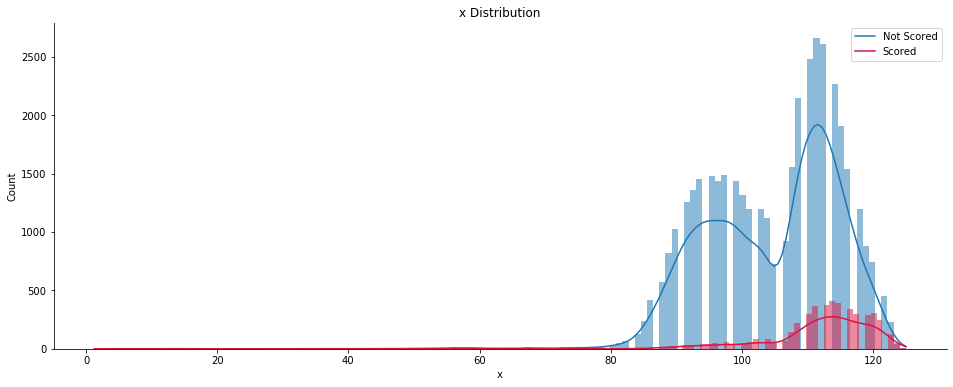

In [16]:
fig, ax = plt.subplots(figsize=(16,6))
ax = sns.histplot(data.loc[data['goal'] == 0, 'x'], kde=True, stat='count', linewidth=0)
ax = sns.histplot(data.loc[data['goal'] == 1, 'x'], color='crimson', kde=True, stat='count', linewidth=0)
ax.set_title('x Distribution')
ax.legend(['Not Scored','Scored'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

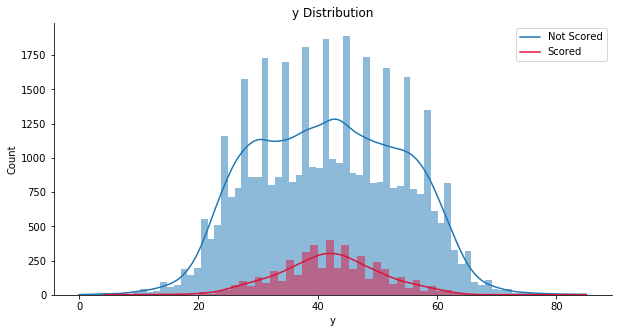

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data.loc[data['goal'] == 0, 'y'], kde=True, stat='count', linewidth=0)
ax = sns.histplot(data.loc[data['goal'] == 1, 'y'], color='crimson', kde=True, stat='count', linewidth=0)
ax.set_title('y Distribution')
ax.legend(['Not Scored','Scored'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

Scored Distribution

|TYPE |	SCORED | % |
----- |-----------|----|
|Head | 873 | 1.93% |
|Foot | 3756 | 8.29% |
|Opportunity | 4602	| 10.16% |
|Free kick | 137 |	0.3% |


# 4. Feature Engineering

## Body Part

Body part should include only foot and head. Left and right root is dependent on the scoring situation, rather than an indicator of power. 

In [18]:
# body part
data['foot'] = np.where((data['rightFoot'] == 1) | (data['leftFoot'] == 1), 1, 0) # [1 if (data.loc[i,'head'] == 0) else 0 for i in range(data.shape[0])]
data.drop(['rightFoot', 'leftFoot'], axis=1, inplace=True)
data.head(2)

,period,time,x,y,freeKick,head,opportunity,goal,competition,foot
0,1,31,113.75,24.65,0,0,0,0,european,1
1,1,143,88.75,24.65,0,0,1,0,european,1


Foot or head might be dropped if regression model is used to avoid multicollinearity.

## Geometry

Position of the shot

In [19]:
# left-yard positions
data.query('x < 62.5').shape[0]

115

In [20]:
# goalpost coordinates
goal_width = 7.32
goal_x = 125
mid_goal_y = 85 / 2
right_post_y = (85 - goal_width) / 2
left_post_y = right_post_y + goal_width
left_post_y = round(left_post_y, 2)

### Distance to the goal
- From shot to left post
- From shot to right post
- From shot to middle of the goal (the mid-point between the goalposts)
- From shot to mid line between goalposts.
- Distance to goal line.

In [21]:
data['distance_left'] = np.sqrt((data['x'] - goal_x)**2 + (data['y'] - left_post_y)**2).round(2)
data['distance_right'] = np.sqrt((data['x'] - goal_x)**2 + (data['y'] - right_post_y)**2).round(2)
data['distance_middle'] = np.sqrt((data['x'] - goal_x)**2 + (data['y'] - mid_goal_y)**2).round(2)
data['distance_midline'] = np.sqrt((data['y'] - mid_goal_y)**2).round(2)
data['distance_goalline'] = np.sqrt((data['x'] - goal_x)**2).round(2)

In [22]:
# display data
data.head(2)

,period,time,x,y,freeKick,head,opportunity,goal,competition,foot,distance_left,distance_right,distance_middle,distance_midline,distance_goalline
0,1,31,113.75,24.65,0,0,0,0,european,1,24.27,18.11,21.10,17.85,11.25
1,1,143,88.75,24.65,0,0,1,0,european,1,42.15,38.93,40.41,17.85,36.25


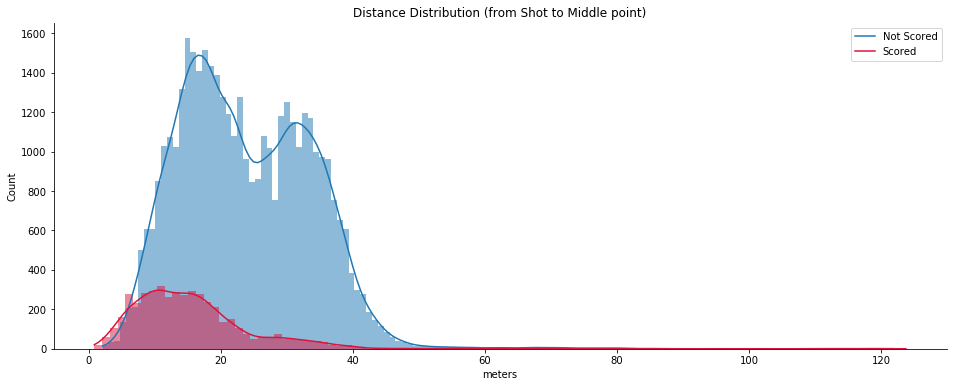

In [23]:
# visualize distance 
fig, ax = plt.subplots(figsize=(16,6))
ax = sns.histplot(data.loc[data['goal'] == 0, 'distance_middle'], kde=True, stat='count', linewidth=0)
ax = sns.histplot(data.loc[data['goal'] == 1, 'distance_middle'], color='crimson', kde=True, stat='count', linewidth=0)
ax.set_title('Distance Distribution (from Shot to Middle point)')
ax.set_xlabel('meters')
ax.legend(['Not Scored','Scored'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

### Angle
- The angle formed between the shot location and the two goal posts --> visible angle.
- Angle formed by midline between goalposts and shot location.

*Angle between Goal Posts and the shot*

In [24]:
# Cosine Law to calculate angle created by shot position and goal posts
cosine_gp = (data['distance_left']**2 + data['distance_right']**2 - goal_width**2) / (2 * data['distance_left'] * data['distance_right'])

# replace 2 observations with cosine less than -1 by -1
cosine_gp[cosine_gp < -1] = -1

# calculate angle
data['gp_angle'] = cosine_gp.apply(lambda x: math.degrees(math.acos(x))).round(2)

*Angle by middle line and distance from shot location to middle goal*

In [25]:
tan_mg = data['distance_midline'] / data['distance_goalline']
data['mg_angle'] = tan_mg.apply(lambda x: math.degrees(math.atan(x))).round(2)

In [26]:
# display data
data.head(2)

,period,time,x,y,freeKick,head,opportunity,goal,competition,foot,distance_left,distance_right,distance_middle,distance_midline,distance_goalline,gp_angle,mg_angle
0,1,31,113.75,24.65,0,0,0,0,european,1,24.27,18.11,21.10,17.85,11.25,10.82,57.78
1,1,143,88.75,24.65,0,0,1,0,european,1,42.15,38.93,40.41,17.85,36.25,9.31,26.22


## One-hot Encoding Categorical Variable

In [27]:
data = pd.get_dummies(data, columns=['competition'], prefix='com', drop_first=True)

In [28]:
# display data
data.head(2).style

,period,time,x,y,freeKick,head,opportunity,goal,foot,distance_left,distance_right,distance_middle,distance_midline,distance_goalline,gp_angle,mg_angle,com_european,com_france,com_germany,com_italy,com_spain,com_worldcup
0,1,31,113.750000,24.650000,0,0,0,0,1,24.270000,18.110000,21.100000,17.850000,11.250000,10.820000,57.780000,1,0,0,0,0,0
1,1,143,88.750000,24.650000,0,0,1,0,1,42.150000,38.930000,40.410000,17.850000,36.250000,9.310000,26.220000,1,0,0,0,0,0


## Verify dataset

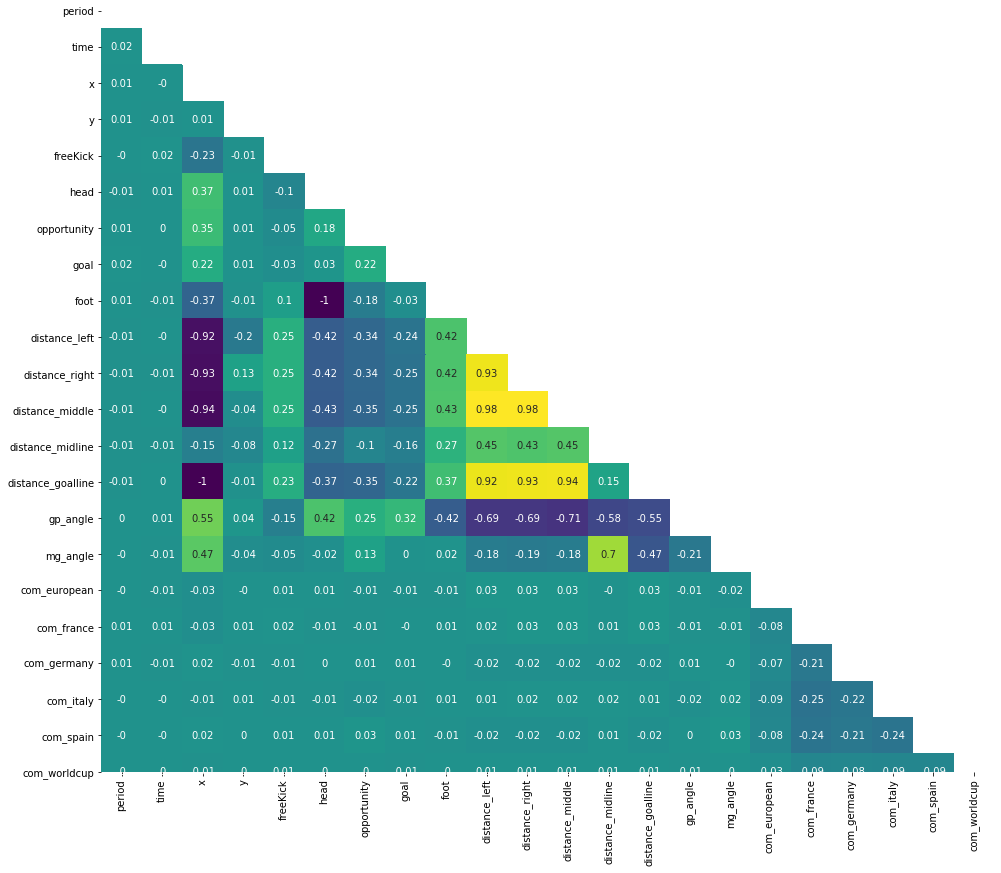

In [29]:
# correlation matrix among features
corr = data.corr().round(2)

plt.figure(figsize=(16,14))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True,cmap='viridis', cbar=False);

Some observations:
- period and time -> drop as the dataset considers single shot, not the time intensity or interaction between goals and time.
- body part has a perfect correlation --> drop head as head has correlation with distance as well.
- x,y coordinates have high correlation to distance --> drop.
- distance_middle --> drop as it has high correlation with other variables.

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45287 entries, 0 to 45286
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   period             45287 non-null  int64  
 1   time               45287 non-null  int64  
 2   x                  45287 non-null  float64
 3   y                  45287 non-null  float64
 4   freeKick           45287 non-null  int64  
 5   head               45287 non-null  int64  
 6   opportunity        45287 non-null  int64  
 7   goal               45287 non-null  int64  
 8   foot               45287 non-null  int64  
 9   distance_left      45287 non-null  float64
 10  distance_right     45287 non-null  float64
 11  distance_middle    45287 non-null  float64
 12  distance_midline   45287 non-null  float64
 13  distance_goalline  45287 non-null  float64
 14  gp_angle           45287 non-null  float64
 15  mg_angle           45287 non-null  float64
 16  com_european       452

The data looks good for the model.

# 5. Expected Model

In [31]:
# dataset for Logistic Model
X = data.copy()
X.drop(['period','time','x','y','head','distance_middle','goal'], axis=1, inplace=True)
y = data['goal'].copy()

In [32]:
# split data into train and test set
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

### Logistic Regression

In [33]:
lr = LogisticRegression(solver= 'liblinear', random_state=seed)
y_pred_lr = lr.fit(X_train, y_train).predict(X_test)

In [34]:
y_test[y_test == 1].count()

1362

There are 1362 goals in the test set.

------------------------------------------
Performance on Test Set
------------------------------------------
90.40% accuracy can be achieved through Logistic Regression

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     12225
           1       0.63      0.11      0.18      1362

    accuracy                           0.90     13587
   macro avg       0.77      0.55      0.56     13587
weighted avg       0.88      0.90      0.87     13587



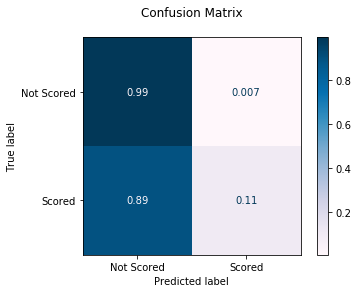

In [35]:
# performance
print('------------------------------------------\nPerformance on Test Set\n------------------------------------------')
acc_score_lr = accuracy_score(y_test, y_pred_lr)
print('{:.2f}% accuracy can be achieved through Logistic Regression\n'.format(acc_score_lr*100))

# classification report
print(classification_report(y_test, y_pred_lr))

# confusion matrix
plot_confusion_matrix(lr, X_test, y_test, normalize='true', cmap='PuBu', display_labels=['Not Scored','Scored'])
plt.title('Confusion Matrix\n');

The classification is highly bias as the model most of the time predict 0 (the majority of the case). This is due to imbalanced dataset --> use this model with balanced dataset by synthesizing training data. 

**Balanced Dataset**

In [36]:
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_sample(X_train, y_train)

------------------------------------------
Performance on Test Set
------------------------------------------
78.30% accuracy can be achieved through Logistic Regression with balancing

              precision    recall  f1-score   support

           0       0.93      0.82      0.87     12225
           1       0.23      0.48      0.31      1362

    accuracy                           0.78     13587
   macro avg       0.58      0.65      0.59     13587
weighted avg       0.86      0.78      0.81     13587



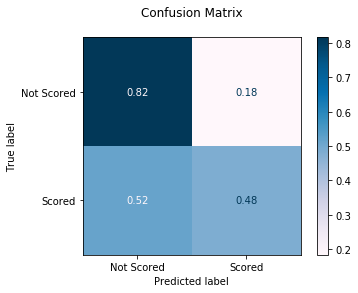

In [37]:
lr_bal = LogisticRegression(solver= 'liblinear', random_state=seed)
y_pred_lr_bal = lr_bal.fit(X_sm, y_sm).predict(X_test)

# performance
print('------------------------------------------\nPerformance on Test Set\n------------------------------------------')
acc_score_lr_bal = accuracy_score(y_test, y_pred_lr_bal)
print('{:.2f}% accuracy can be achieved through Logistic Regression with balancing\n'.format(acc_score_lr_bal*100))

# classification report
print(classification_report(y_test, y_pred_lr_bal))

# confusion matrix
plot_confusion_matrix(lr_bal, X_test, y_test, normalize='true', cmap='PuBu', display_labels=['Not Scored','Scored'])
plt.title('Confusion Matrix\n');

The model performs better as the classification of the minority observations is much precise.

**Fine tune model**

C LogisticRegression(C=0.10848096388007433, random_state=42, solver='liblinear')
ROC AUC: 0.8206
Accuracy: 0.78


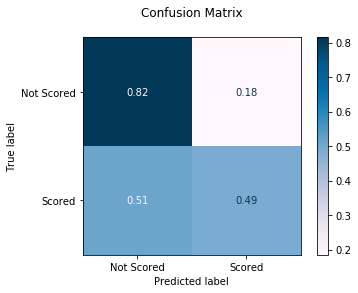

In [38]:
lr_ = LogisticRegression(solver= 'liblinear', random_state=seed)

# Search parameters for gridsearchcv
param_grid = {'C': np.logspace(-3, 0.1, 100)}

clf = GridSearchCV(estimator=lr_, param_grid=param_grid, scoring='neg_log_loss', n_jobs=-1)
clf.fit(X_sm, y_sm)
print('C', clf.best_estimator_)

scoring = {'roc_aug': 'roc_auc'}
score_cv = cross_validate(clf, X=X_train, y=y_train, scoring=scoring, n_jobs=-1)
print('ROC AUC:', score_cv['test_roc_aug'].mean().round(4))

y_pred = clf.predict(X_test)
print('Accuracy: ' + str(accuracy_score(y_test, y_pred).round(2)))

# confusion matrix
plot_confusion_matrix(clf, X_test, y_test, normalize='true', cmap='PuBu', display_labels=['Not Scored','Scored'])
plt.title('Confusion Matrix\n');

=> Finalize model

### Decision Tree

In [39]:
rf = RandomForestClassifier(random_state=seed)

random_grid = {'bootstrap': [True, False],
               'max_depth': [3, 4, 5, 6, 7, 8, 10, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [0.1, 0.2, 0.4],
               'n_estimators': [200, 300, 400, 500]}

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter = 100, cv=3, verbose=2, n_jobs=-1)
rf_random.fit(X_sm, y_sm)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.9min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 10,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [0.1, 0.2, 0.4],
                                        'n_estimators': [200, 300, 400, 500]},
                   verbose=2)

Random Forest has great performance on test set and the model is able to identify much goals.

In [40]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=8, max_features='sqrt',
                       min_samples_leaf=0.1, n_estimators=200, random_state=42)

------------------------------------------
Performance on Test Set
------------------------------------------
69.96% accuracy can be achieved through Random Forest with balancing

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     12225
           1       0.21      0.72      0.33      1362

    accuracy                           0.70     13587
   macro avg       0.58      0.71      0.57     13587
weighted avg       0.88      0.70      0.76     13587



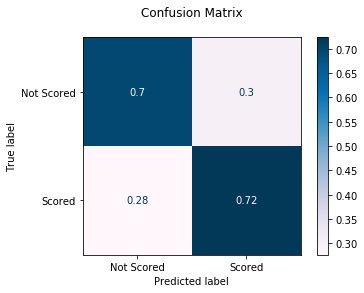

In [41]:
rf_clf = RandomForestClassifier(bootstrap=False, max_depth=3,
                                min_samples_leaf=0.1, n_estimators=300, random_state=42).fit(X_sm, y_sm)

y_pred_rf = rf_clf.predict(X_test)

# performance
print('------------------------------------------\nPerformance on Test Set\n------------------------------------------')
acc_score_rf = accuracy_score(y_test, y_pred_rf)
print('{:.2f}% accuracy can be achieved through Random Forest with balancing\n'.format(acc_score_rf*100))

# classification report
print(classification_report(y_test, y_pred_rf))

# confusion matrix
plot_confusion_matrix(rf_clf, X_test, y_test, normalize='true', cmap='PuBu', display_labels=['Not Scored','Scored'])
plt.title('Confusion Matrix\n');

### Model Evaluation

**ROC Curve**

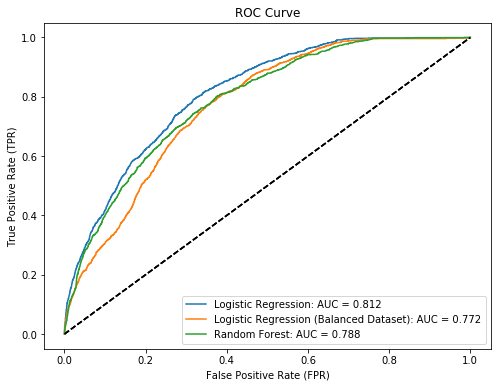

In [42]:
y_pred_proba_lr = lr.predict_proba(X_test)
y_pred_proba_lr_bal = lr_bal.predict_proba(X_test)
y_pred_proba_rf = rf_clf.predict_proba(X_test)

plt.figure(figsize=(8,6))

for test, pred, name in zip([y_test, y_test, y_test], [y_pred_proba_lr[:,1], y_pred_proba_lr_bal[:,1], y_pred_proba_rf[:,1]], 
                            ['Logistic Regression','Logistic Regression (Balanced Dataset)','Random Forest']):
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC Curve')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)');

**Gain Chart**

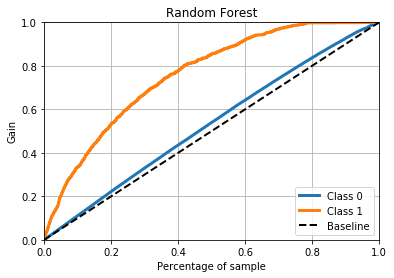

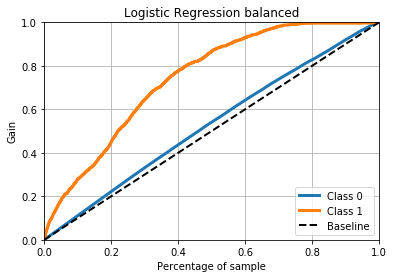

In [43]:
skplt.metrics.plot_cumulative_gain(y_test, y_pred_proba_rf, title='Random Forest')
skplt.metrics.plot_cumulative_gain(y_test, y_pred_proba_lr_bal, title='Logistic Regression balanced');

### Features Importance

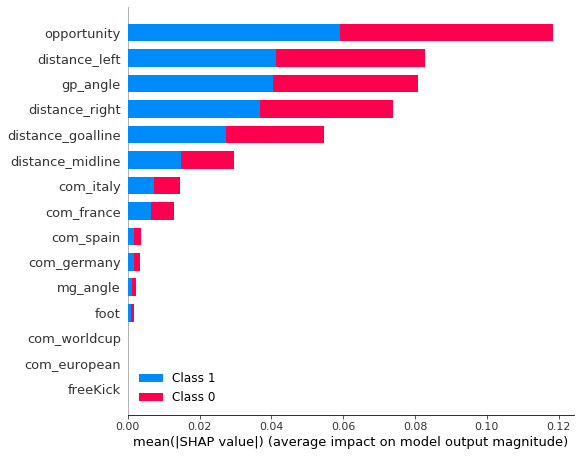

In [44]:
explainer = shap.TreeExplainer(rf_clf)
s_values = explainer.shap_values(X_test)
shap.summary_plot(s_values, X_test, plot_type='bar');
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

Opportunity is highly important and push the scoring probability. Distance to the goalpost and angle between goalposts are key drivers for scoring chance.

In [46]:
# shap.initjs()
# shap.force_plot(explainer.expected_value, s_values[1], X_test.iloc[1,:], link="logit")

In [48]:
# fig, ax = plt.subplots(figsize=(16, 8))
# pitch = Pitch(orientation='vertical', view='half', tight_layout=False, goal_type='box', pad_bottom=-20)
# pitch.draw(ax=ax)
# sc1 = pitch.scatter(data.loc[4,'x'], data.loc[4,'y'], marker='football', s=600, ax=ax, label='Shooter', zorder=1.2)
# # legend = ax.legend(labelspacing=1, fontsize=12)
# # ax.set_title('Goal', fontsize=15)

# shap.initjs()
# shap.force_plot(explainer.expected_value, s_values[4], X_test.iloc[4,:], link='logit', matplotlib=True)

Overall shot map. Binning approximately 2 metre square grid. Count of shots in each grid cell.

In [49]:
X_ = data[['x','y']]
Xt, Xtest, ytrain, ytest = train_test_split(X_, y, test_size=0.3, random_state=42)

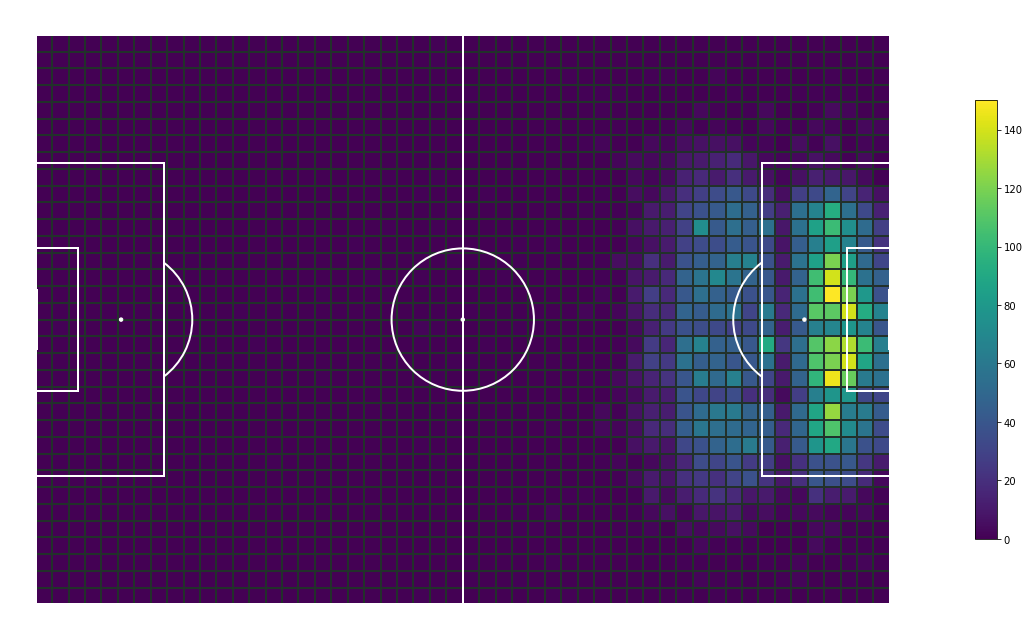

In [50]:
pitch = Pitch(pitch_type='statsbomb', figsize=(16, 9), line_zorder=2, line_color='white', orientation='horizontal')

fig, ax = pitch.draw()
bs = pitch.bin_statistic(Xtest['x'], Xtest['y'], statistic='count', bins=(52, 34))
pcm = pitch.heatmap(bs, ax=ax, cmap='viridis', edgecolors='#22312b')
fig.colorbar(pcm, fraction=0.045, shrink=0.7);

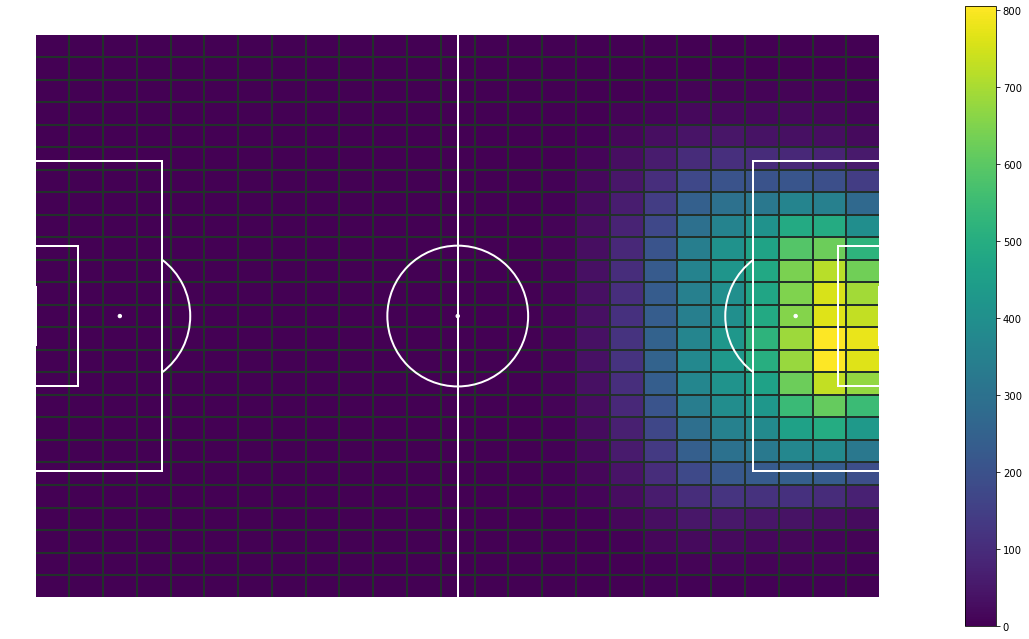

In [51]:
pitch = Pitch(pitch_type='statsbomb', figsize=(16, 9), line_zorder=2, line_color='white', orientation='horizontal')

fig, ax = pitch.draw()
bin_statistic = pitch.bin_statistic(X_.x, X_.y, statistic='count', bins=(25, 25))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='viridis', edgecolors='#22312b')
cbar = fig.colorbar(pcm, ax=ax)

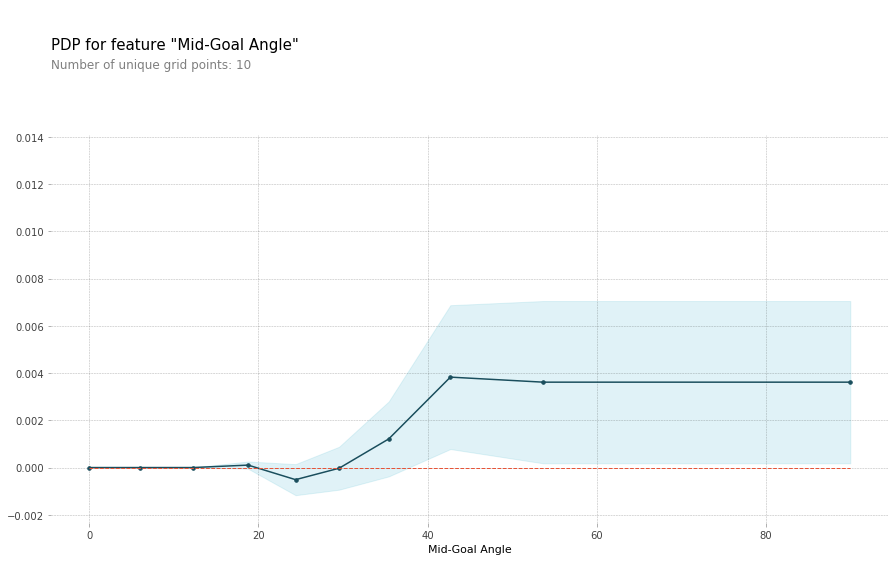

In [55]:
mpl.rcParams['font.family'] = ['DejaVuSans']
pdp_goals = pdp.pdp_isolate(model=rf_clf, dataset=X_test, model_features=X_test.columns, feature='mg_angle')
pdp.pdp_plot(pdp_goals, 'Mid-Goal Angle');

Angle between the shot location and midline goal post around 45 degree has higher chance to score.

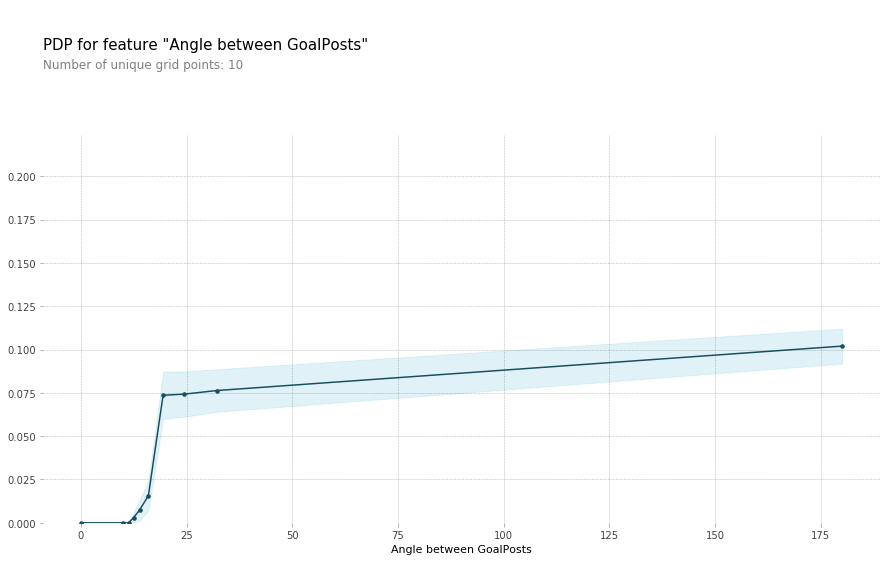

In [57]:
pdp_goals = pdp.pdp_isolate(model=rf_clf, dataset=X_test, model_features=X_test.columns, feature='gp_angle')
pdp.pdp_plot(pdp_goals, 'Angle between GoalPosts');

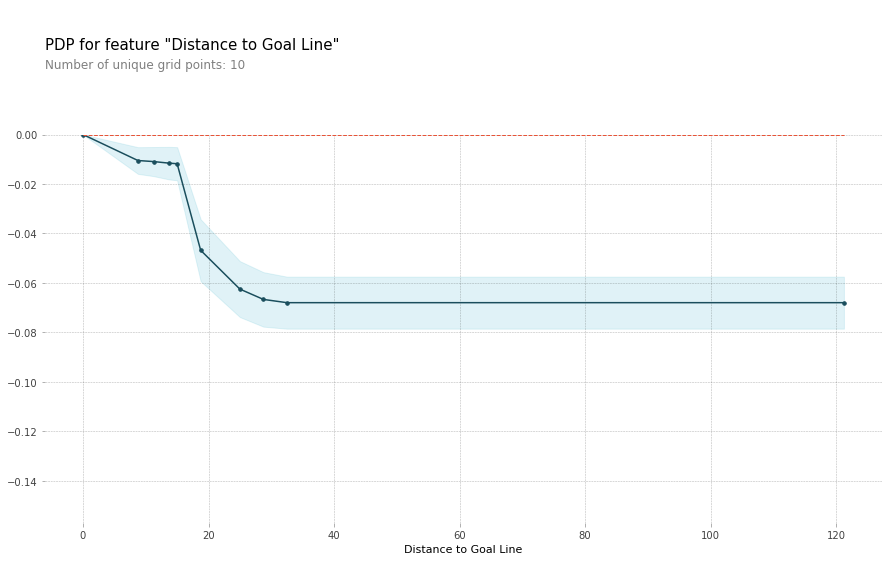

In [58]:
pdp_goals = pdp.pdp_isolate(model=rf_clf, dataset=X_test, model_features=X_test.columns, feature='distance_goalline')
pdp.pdp_plot(pdp_goals, 'Distance to Goal Line');

The figure shows that the probability of scoring a goal is around 10% lower when distance to the goal line is in the range of 10-30 meters. 

# Conclusion

Some improvements if there are data about:
- Goalkeeper positions, scored trajectories and some pre-shot events (pass, cross and fancy dribbling).
- Number of other defenders around the ball before shooting.